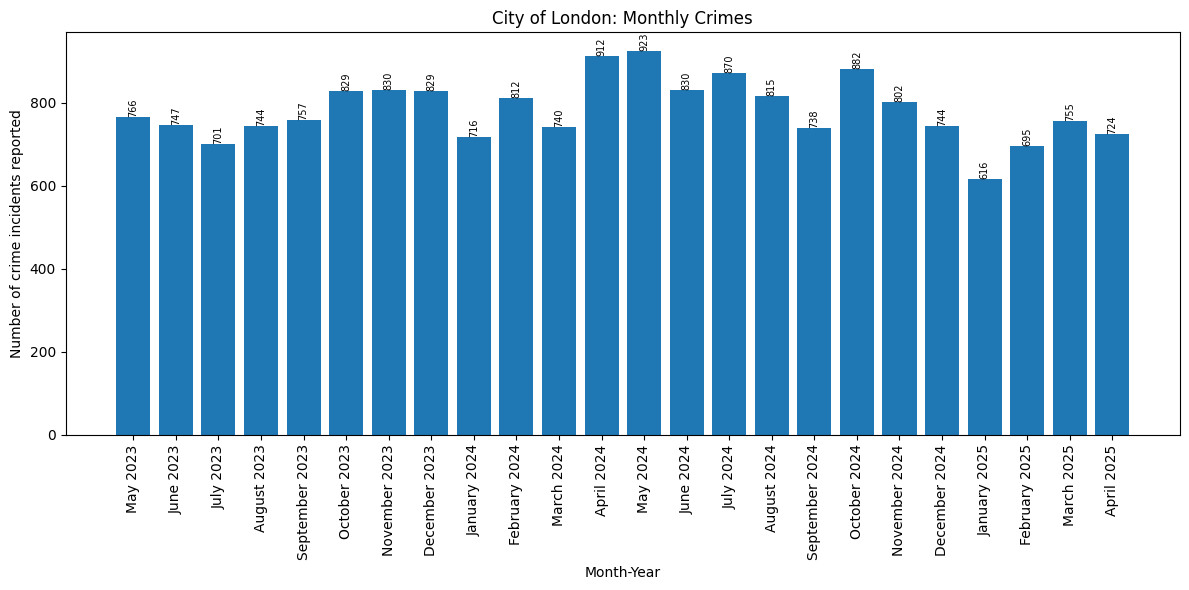

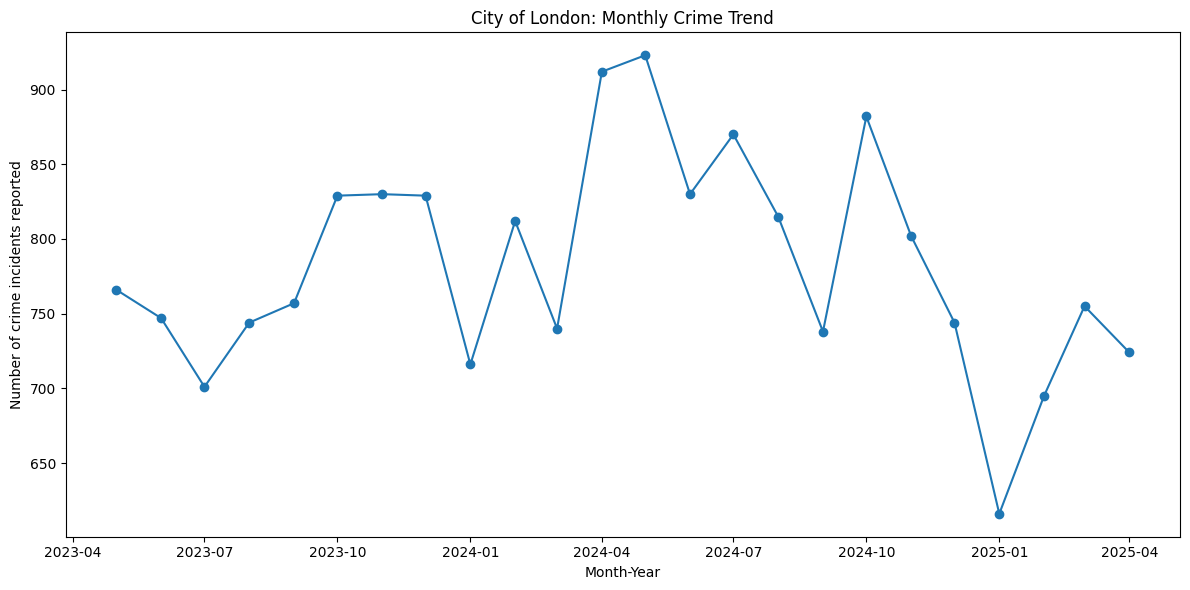

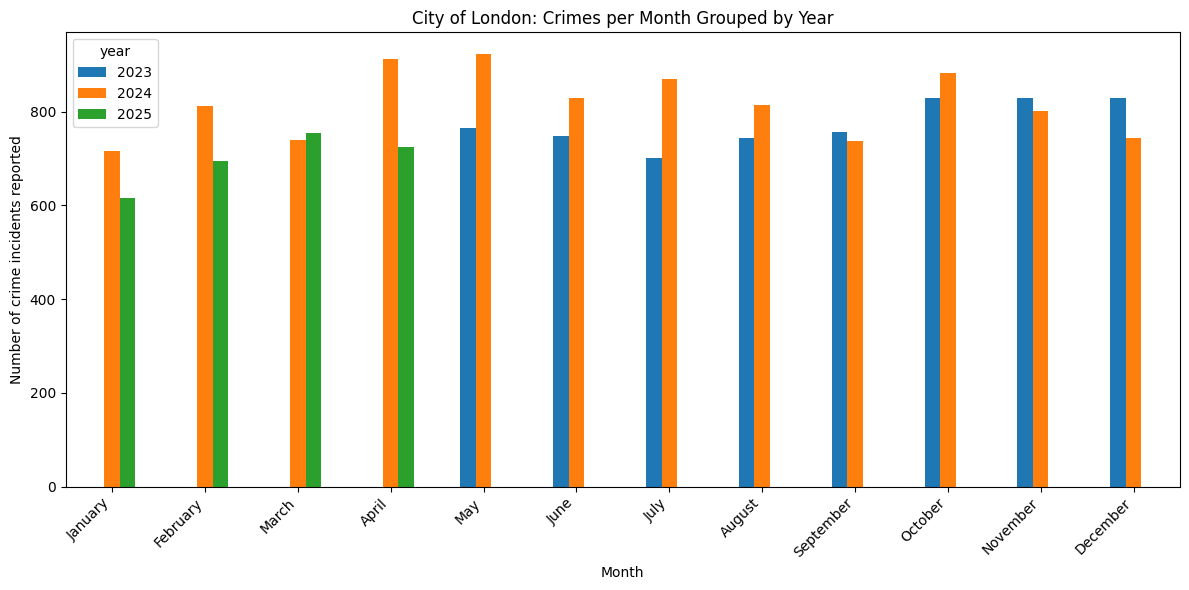

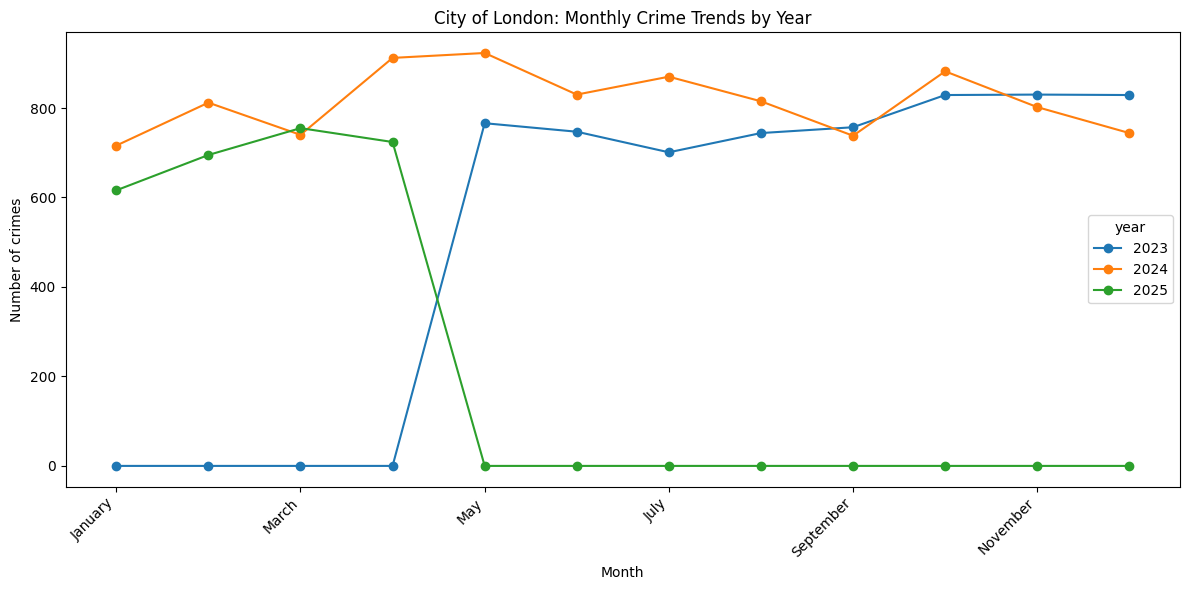

In [3]:
#Temporal analysis plots using the CLEANED dataset 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load cleaned data
cleaned_path = Path("C:/Users/rohit/OneDrive/Desktop/Uni/Dissertation/cleaned_dataset/cleaned_city_of_london_crime_for_temporal_analysis.csv")
cleaned_df = pd.read_csv(cleaned_path)

# Re-parse datetime as CSV will have saved it as text
#Prefer the saved 'month_dt' if present; else fall back to 'month' (YYYY-MM)
if "month_dt" in cleaned_df.columns:
    cleaned_df["month_dt"] = pd.to_datetime(cleaned_df["month_dt"], errors="coerce")
elif "month" in cleaned_df.columns:
    # UK Police format is typically YYYY-MM
    try:
        cleaned_df["month_dt"] = pd.to_datetime(cleaned_df["month"], format="%Y-%m")
    except Exception:
        cleaned_df["month_dt"] = pd.to_datetime(cleaned_df["month"], errors="coerce")
else:
    raise ValueError("No usable month field found in cleaned dataset.")

# Keep valid months only 
cleaned_df = cleaned_df[~cleaned_df["month_dt"].isna()].copy()

# Rebuild helper fields (robust even if CSV lost dtypes)
cleaned_df["year"] = cleaned_df["month_dt"].dt.year
cleaned_df["month_num"] = cleaned_df["month_dt"].dt.month
cleaned_df["month_name"] = cleaned_df["month_dt"].dt.month_name()
cleaned_df["year_month_period"] = cleaned_df["month_dt"].dt.to_period("M")
cleaned_df["year_month_label"] = cleaned_df["month_dt"].dt.strftime("%B %Y")

# Aggregating counts per exact Year-Month (e.g., 2023-05, 2023-06, ...)
ym_counts = (
    cleaned_df.groupby("year_month_period")
              .size()
              .rename("crime_count")
              .reset_index()
)
ym_counts["month_dt"] = ym_counts["year_month_period"].dt.to_timestamp()
ym_counts["year_month_label"] = ym_counts["month_dt"].dt.strftime("%B %Y")
ym_counts = ym_counts.sort_values("month_dt").reset_index(drop=True)

# Creating Pivot for “same month across years” comparison
month_order = list(range(1, 13))
month_name_order = [pd.Timestamp(2000, m, 1).strftime("%B") for m in month_order]

pivot_counts = (
    cleaned_df.assign(month_name=cleaned_df["month_dt"].dt.month_name())
              .pivot_table(
                  index="year",
                  columns="month_name",
                  values="crime_id",    # counts by crime_id
                  aggfunc="count",
                  fill_value=0
              )
              .reindex(columns=month_name_order, fill_value=0)
)


# Bar Graph for each month across the full period of 24 months
plt.figure(figsize=(12, 6))
plt.bar(ym_counts["year_month_label"], ym_counts["crime_count"])
plt.xticks(rotation=90)
plt.xlabel("Month-Year")
plt.ylabel("Number of crime incidents reported")
plt.title("City of London: Monthly Crimes")
for i, v in enumerate(ym_counts["crime_count"].tolist()):
    plt.text(i, v, str(v), ha="center", va="bottom", fontsize=7, rotation=90)
plt.tight_layout()
plt.show()

# (b) Line graphy to visualise monthly trend
plt.figure(figsize=(12, 6))
plt.plot(ym_counts["month_dt"], ym_counts["crime_count"], marker="o")
plt.xlabel("Month-Year")
plt.ylabel("Number of crime incidents reported")
plt.title("City of London: Monthly Crime Trend")
plt.tight_layout()
plt.show()

# (c) Grouped bar: months grouped by year
pivot_counts.T.plot(kind="bar", figsize=(12, 6))
plt.xlabel("Month")
plt.ylabel("Number of crime incidents reported")
plt.title("City of London: Crimes per Month Grouped by Year")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# (d) Grouped line: months (x) with a line per year
pivot_counts.T.plot(kind="line", marker="o", figsize=(12, 6))
plt.xlabel("Month")
plt.ylabel("Number of crimes")
plt.title("City of London: Monthly Crime Trends by Year")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
